##  Analyse der Verkaufsdaten

In diesem Notebook analysieren wir Verkaufsdaten der Fair-Trade-Plattform *El Puente*. Die Daten stammen aus zwei geografischen Regionen: Deutschland und dem restlichen Europa. Ziel ist es, die Umsatzentwicklung pro Produkt über die Zeit hinweg zu untersuchen.

##  Methodik

Die Daten werden zuerst zusammengeführt und bereinigt. Danach führen wir eine gruppierte Analyse durch – unter anderem nach Monat, Ort und Produkt. Dadurch lassen sich zeitliche Trends sowie Unterschiede zwischen Produktkategorien erkennen.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Dictionary zur Umwandlung deutscher Monatskürzel in Monatszahlen
monat_dict = {
    "Jan": 1, "Feb": 2, "Mrz": 3, "Apr": 4, "Mai": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Okt": 10, "Nov": 11, "Dez": 12
}

# Excel-Datei mit mehreren Sheets wird vollständig eingelesen
xls_file = pd.read_excel("Shop_Data.xlsx", sheet_name=None)

# Leere Liste zur Zwischenspeicherung der bereinigten DataFrames
data_freme_list = []

# Iteration über alle Tabellenblätter in der Excel-Datei
for sheet_name, data_freme in xls_file.items():
    
    # Erstellen eines vollständigen Datumsstrings: "01.Monat.2021"
    # z.B. "Mrz" → "01.03.2021", dann Umwandlung zu Datetime-Format
    data_freme["Datum"] = "01." + data_freme["Datum"].map(monat_dict).astype(int).astype(str).str.zfill(2) + ".2021"
    data_freme["Datum"] = pd.to_datetime(data_freme["Datum"], format="%d.%m.%Y")

    # Umbenennung der Produkte: z. B. P1 → A, P2 → B, ...
    produkt_dict = {"P1": "A", "P2": "B", "P3": "C"}
    data_freme["Produkt"] = produkt_dict.get(sheet_name, sheet_name)
    
    # Festlegen, dass die Daten aus dem deutschen Ort stammen
    #data_freme["Ort"] = "DE"

    # Auswahl nur relevanter Spalten
    data_freme_clean = data_freme[["Datum", "Produkt", "Umsatz"]]# +"Ort"
    
    # Hinzufügen des bereinigten DataFrames zur Liste
    data_freme_list.append(data_freme_clean)

# Alle Einzeldaten zu einem DataFrame zusammenfügen
data_freme_de = pd.concat(data_freme_list, ignore_index=True)

In [11]:
data_freme_de.head()

,Datum,Produkt,Umsatz
0,2021-01-01,C,148945.166650
1,2021-02-01,C,128859.949494
2,2021-03-01,C,141602.709028
3,2021-04-01,C,133780.491099
4,2021-05-01,C,135993.779232


In [12]:
# Einlesen der CSV-Datei mit europäischer Shopauswertung
# - Trennzeichen ist Semikolon (;)
# - Die Spalte "Datum" wird direkt als Datumsformat interpretiert
data_freme_eu_all = pd.read_csv("Shopauswertung.csv", delimiter=";", parse_dates=["Datum"])

# Überprüfung auf fehlende Werte (NaNs) in allen Spalten
data_freme_eu_all.isna().sum()

Datum      0
Produkt    0
Umsatz     0
dtype: int64

In [13]:
duplicate = data_freme_eu_all.duplicated()

In [14]:
duplicate.sum()

0

In [15]:
# Extraktion der Daten für Produkt A, B und die kombinierte Zeile A+B+C
data_freme_a = data_freme_eu_all[data_freme_eu_all["Produkt"] == "A"].copy()
data_freme_b = data_freme_eu_all[data_freme_eu_all["Produkt"] == "B"].copy()
data_freme_abc = data_freme_eu_all[data_freme_eu_all["Produkt"] == "A+B+C"].copy()

# Mergen der Umsatzwerte von A zum kombinierten A+B+C-Eintrag (nach Datum)
data_freme_abc = data_freme_abc.merge(
    data_freme_a[["Datum", "Umsatz"]],
    on="Datum",
    how="left",
    suffixes=("", "_A")
)

# Mergen der Umsatzwerte von B ebenfalls zu A+B+C
data_freme_abc = data_freme_abc.merge(
    data_freme_b[["Datum", "Umsatz"]],
    on="Datum",
    how="left",
    suffixes=("", "_B")
)

# Berechnung des Umsatzes für Produkt C durch Differenzbildung:
# A+B+C - A - B = C
data_freme_abc["Umsatz_C"] = (
    data_freme_abc["Umsatz"] - data_freme_abc["Umsatz_A"] - data_freme_abc["Umsatz_B"]
)

# Erstellen eines neuen DataFrames für Produkt C
data_freme_c = data_freme_abc[["Datum", "Umsatz_C"]].copy()
data_freme_c.rename(columns={"Umsatz_C": "Umsatz"}, inplace=True)
data_freme_c["Produkt"] = "C"

# Zusammensetzen aller Produkte (A, B, berechnetes C) in einem DataFrame
data_freme_eu = pd.concat([
    data_freme_a[["Datum", "Produkt", "Umsatz"]],
    data_freme_b[["Datum", "Produkt", "Umsatz"]],
    data_freme_c[["Datum", "Produkt", "Umsatz"]]
], ignore_index=True)

In [16]:
# Weist der Spalte "Ort" im DataFrame data_freme_de den Wert "DE" zu
data_freme_de["Ort"] = "DE"

# Weist der Spalte "Ort" im DataFrame data_freme_eu den Wert "EU" zu
data_freme_eu["Ort"] = "EU"

In [17]:
# Konvertiert die Spalte "Datum" im DataFrame data_freme_eu in Datetime-Objekte, wobei der Tag zuerst angegeben ist
data_freme_eu["Datum"] = pd.to_datetime(data_freme_eu["Datum"], dayfirst=True)

# Erstellt eine neue Spalte "Monat", die den Zeitraum (Periode) im Monatsformat aus der "Datum"-Spalte extrahiert
data_freme_eu["Monat"] = data_freme_eu["Datum"].dt.to_period("M")

# Gruppiert die Daten nach "Monat" und "Produkt" und summiert den Umsatz; das Ergebnis wird zurückgesetzt, um einen DataFrame zu erhalten
umsatz_eu_monat = data_freme_eu.groupby(["Monat", "Produkt"])["Umsatz"].sum().reset_index()

# Fügt der resultierenden Tabelle eine neue Spalte "Ort" mit dem Wert "EU" hinzu
umsatz_eu_monat["Ort"] = "EU"

In [18]:
# Erstellt eine neue Spalte "Monat", die den Zeitraum (Periode) im Monatsformat aus der "Datum"-Spalte extrahiert
data_freme_de["Monat"] = data_freme_de["Datum"].dt.to_period("M")

# Fügt der DataFrame eine neue Spalte "Ort" mit dem Wert "DE" hinzu
data_freme_de["Ort"] = "DE"

# Gruppiert die Daten nach "Monat" und "Produkt" und summiert den Umsatz; das Ergebnis wird zurückgesetzt, um einen DataFrame zu erhalten
umsatz_de_monat = data_freme_de.groupby(["Monat", "Produkt"])["Umsatz"].sum().reset_index()

# Fügt der gruppierten Tabelle eine neue Spalte "Ort" mit dem Wert "DE" hinzu
umsatz_de_monat["Ort"] = "DE"

In [19]:
# Fasst die DataFrames umsatz_de_monat und umsatz_eu_monat zusammen und setzt die Indexe zurück; 
# Die Zahlen werden auf zwei Dezimalstellen gerundet
umsatz_gesamt = (pd.concat([umsatz_de_monat, umsatz_eu_monat], ignore_index=True)).round(2)

# Gibt eine statistische Zusammenfassung der numerischen Spalten im DataFrame umsatz_gesamt aus
umsatz_gesamt.describe()

,Umsatz
count,7.200000e+01
mean,5.870413e+05
std,1.270028e+06
min,1.392160e+03
25%,1.660092e+04
50%,2.636737e+04
75%,2.583039e+05
max,5.422696e+06


In [20]:
umsatz_de_monat.describe().round(2)

,Umsatz
count,36.00
mean,57064.66
std,55841.39
min,14055.57
25%,17446.53
50%,20386.26
75%,128886.64
max,148945.17


In [21]:
umsatz_eu_monat.describe().round(2)

,Umsatz
count,36.00
mean,1117018.00
std,1640460.46
min,1392.16
25%,1771.65
50%,272606.76
75%,1731518.50
max,5422696.34


In [22]:
umsatz_gesamt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype    
---  ------   --------------  -----    
 0   Monat    72 non-null     period[M]
 1   Produkt  72 non-null     object   
 2   Umsatz   72 non-null     float64  
 3   Ort      72 non-null     object   
dtypes: float64(1), object(2), period[M](1)
memory usage: 2.4+ KB


In [23]:
umsatz_gesamt.head()

,Monat,Produkt,Umsatz,Ort
0,2021-01,A,15562.55,DE
1,2021-01,B,14774.46,DE
2,2021-01,C,148945.17,DE
3,2021-02,A,14055.57,DE
4,2021-02,B,15176.47,DE


In [24]:
umsatz_gesamt.groupby("Produkt")["Umsatz"].sum()

Produkt
A      220795.17
B     3607767.29
C    38438413.14
Name: Umsatz, dtype: float64

In [25]:
umsatz_gesamt.groupby("Ort")["Umsatz"].sum() 

Ort
DE     2054327.59
EU    40212648.01
Name: Umsatz, dtype: float64

In [26]:
umsatz_gesamt.groupby(["Ort", "Produkt"])["Umsatz"].sum()

Ort  Produkt
DE   A            201430.97
     B            237165.69
     C           1615730.93
EU   A             19364.20
     B           3370601.60
     C          36822682.21
Name: Umsatz, dtype: float64

## Ergebnisse der Produktumsätze

Untenstehendes Diagramm zeigt die Entwicklung des Umsatzes nach Produkt über die Monate hinweg. Die Farben unterscheiden dabei zwischen den einzelnen Produkten. Auffälligkeiten in bestimmten Monaten lassen Rückschlüsse auf saisonale Schwankungen oder Nachfragetrends zu.


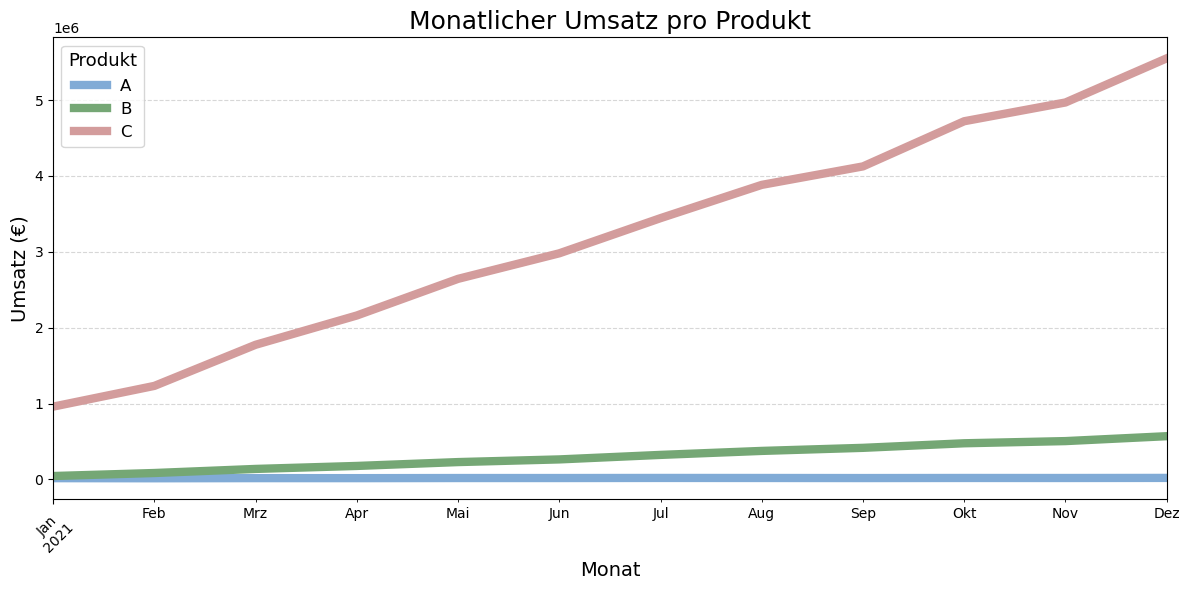

In [27]:
umsatz_gesamt.groupby(["Monat", "Produkt"])["Umsatz"].sum().unstack().plot(
    figsize=(12, 6),
    color=["#81ABD6", "#75A775", "#D39C9C"],
    linewidth=6)


plt.title('Monatlicher Umsatz pro Produkt', fontsize=18)
plt.xlabel('Monat', fontsize=14)
plt.ylabel('Umsatz (€)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Produkt', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

In [28]:
umsatz_gesamt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype    
---  ------   --------------  -----    
 0   Monat    72 non-null     period[M]
 1   Produkt  72 non-null     object   
 2   Umsatz   72 non-null     float64  
 3   Ort      72 non-null     object   
dtypes: float64(1), object(2), period[M](1)
memory usage: 2.4+ KB


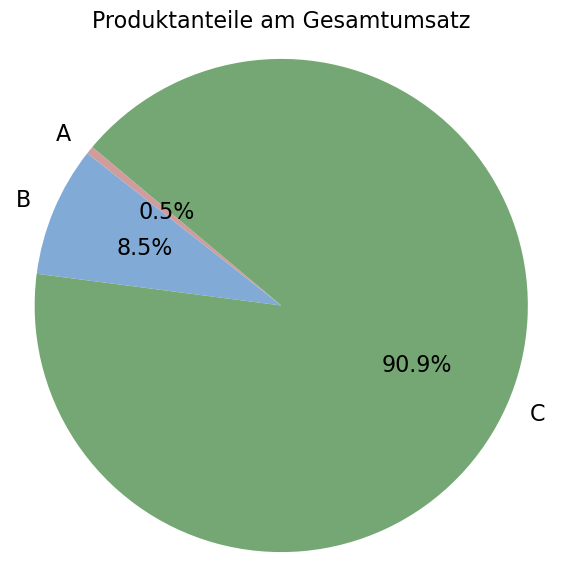

In [29]:
total_sales = umsatz_gesamt.copy()

# Сума продажів по продуктам
sales_by_product = total_sales.groupby('Produkt')['Umsatz'].sum()

# Побудова кругової діаграм
plt.figure(figsize=(7, 7))
plt.pie(
    sales_by_product.values,
    labels=sales_by_product.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=["#D39C9C", "#81ABD6", "#75A775"],
    textprops={'fontsize': 16},
    radius=0.4
)
plt.title('Produktanteile am Gesamtumsatz', fontsize=16)
plt.axis('equal')
plt.show()

In [30]:
data_freme_eu

,Datum,Produkt,Umsatz,Ort,Monat
0,2021-01-01,A,17.132115,EU,2021-01
1,2021-01-02,A,57.353725,EU,2021-01
2,2021-01-03,A,114.746857,EU,2021-01
3,2021-01-04,A,113.251181,EU,2021-01
4,2021-01-05,A,4.186462,EU,2021-01
...,...,...,...,...,...
1090,2021-12-27,C,179599.092458,EU,2021-12
1091,2021-12-28,C,179634.598528,EU,2021-12
1092,2021-12-29,C,179835.358062,EU,2021-12
1093,2021-12-30,C,180574.572178,EU,2021-12


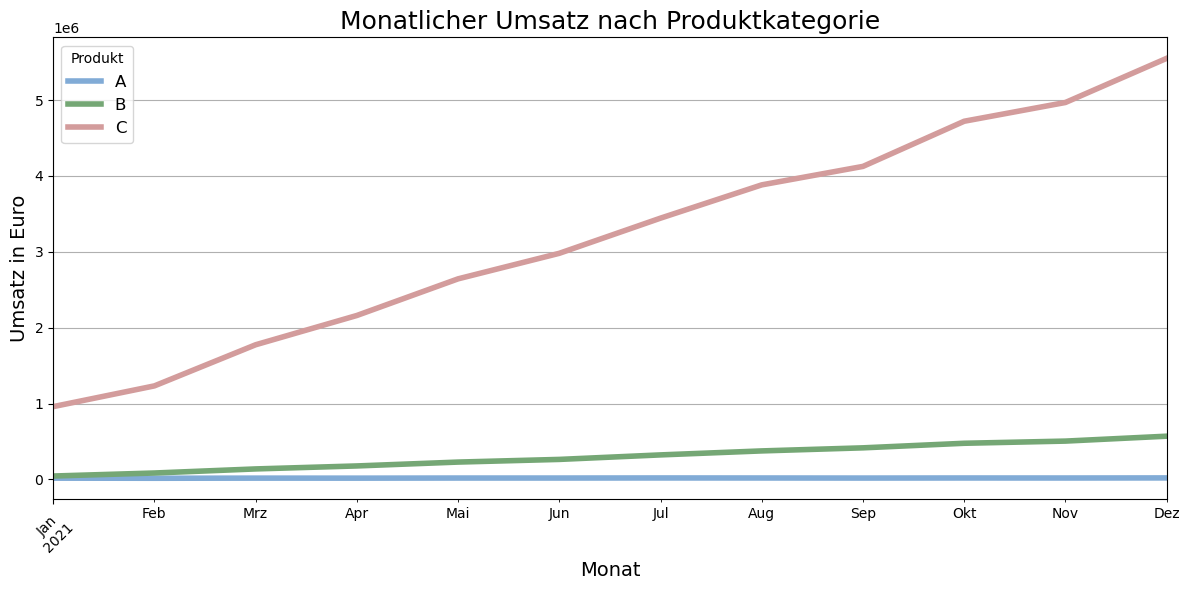

In [31]:
umsatz_gesamt.groupby(["Monat", "Produkt"])["Umsatz"].sum().unstack().plot(
    figsize=(12, 6), 
    color=["#81ABD6", "#75A775", "#D39C9C"],  
    linewidth=4  
)


plt.title("Monatlicher Umsatz nach Produktkategorie", fontsize=18)
plt.xlabel("Monat", fontsize=14)
plt.ylabel("Umsatz in Euro", fontsize=14)
plt.grid(True)
plt.legend(title="Produkt", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

In [32]:
durchschnitt_umsatz = umsatz_gesamt.groupby(['Produkt', 'Ort'])['Umsatz'].mean().reset_index()


durchschnitt_umsatz['Umsatz'] = durchschnitt_umsatz['Umsatz'].round(2)

durchschnitt_umsatz

,Produkt,Ort,Umsatz
0,A,DE,16785.91
1,A,EU,1613.68
2,B,DE,19763.81
3,B,EU,280883.47
4,C,DE,134644.24
5,C,EU,3068556.85


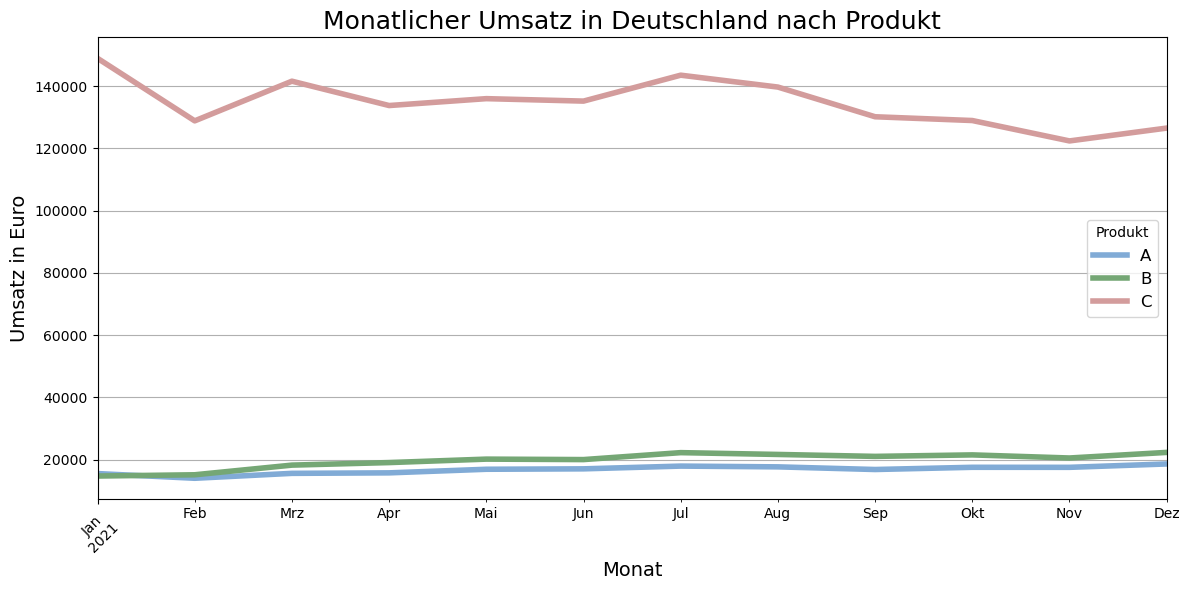

In [33]:
umsatz_de_monat.groupby(["Monat", "Produkt"])["Umsatz"].sum().unstack().plot(
    figsize=(12, 6),
    color=["#81ABD6", "#75A775", "#D39C9C"],
    linewidth=4
)


plt.title("Monatlicher Umsatz in Deutschland nach Produkt", fontsize=18)
plt.xlabel("Monat", fontsize=14)
plt.ylabel("Umsatz in Euro", fontsize=14)
plt.grid(True)
plt.legend(title="Produkt", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

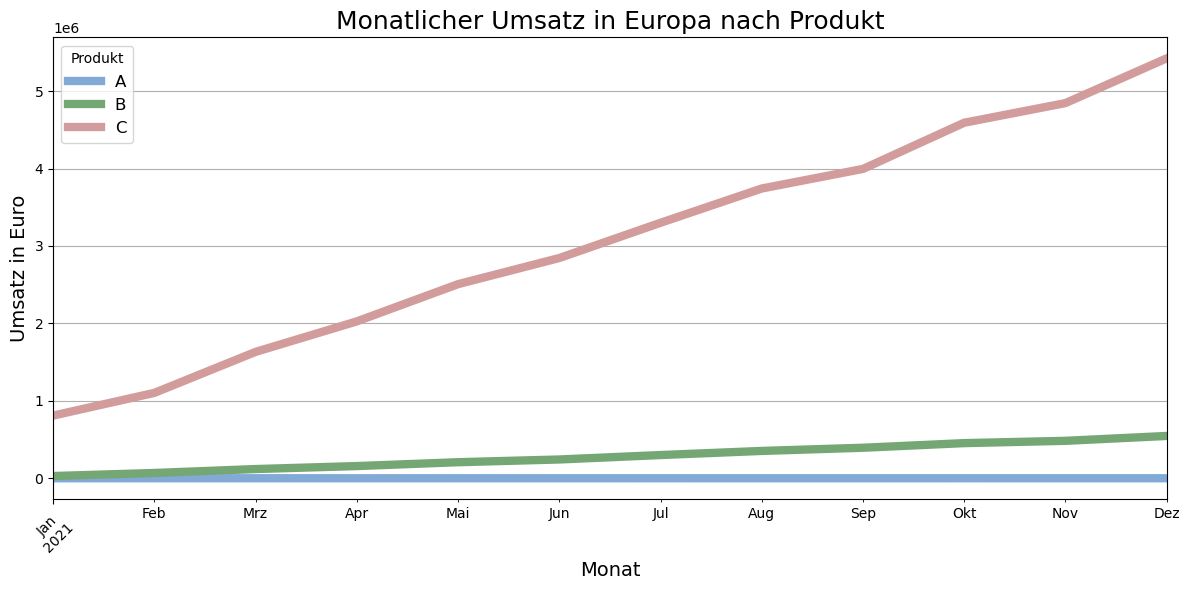

In [34]:
umsatz_eu_monat.groupby(["Monat", "Produkt"])["Umsatz"].sum().unstack().plot(
    figsize=(12, 6),
    color=["#81ABD6", "#75A775", "#D39C9C"],
    linewidth=6
)


plt.title("Monatlicher Umsatz in Europa nach Produkt", fontsize=18)
plt.xlabel("Monat", fontsize=14)
plt.ylabel("Umsatz in Euro", fontsize=14)
plt.grid(True)
plt.legend(title="Produkt", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
umsatz_gesamt

,Monat,Produkt,Umsatz,Ort
0,2021-01,A,15562.55,DE
1,2021-01,B,14774.46,DE
2,2021-01,C,148945.17,DE
3,2021-02,A,14055.57,DE
4,2021-02,B,15176.47,DE
...,...,...,...,...
67,2021-11,B,484820.02,EU
68,2021-11,C,4845068.92,EU
69,2021-12,A,1603.26,EU
70,2021-12,B,547672.49,EU


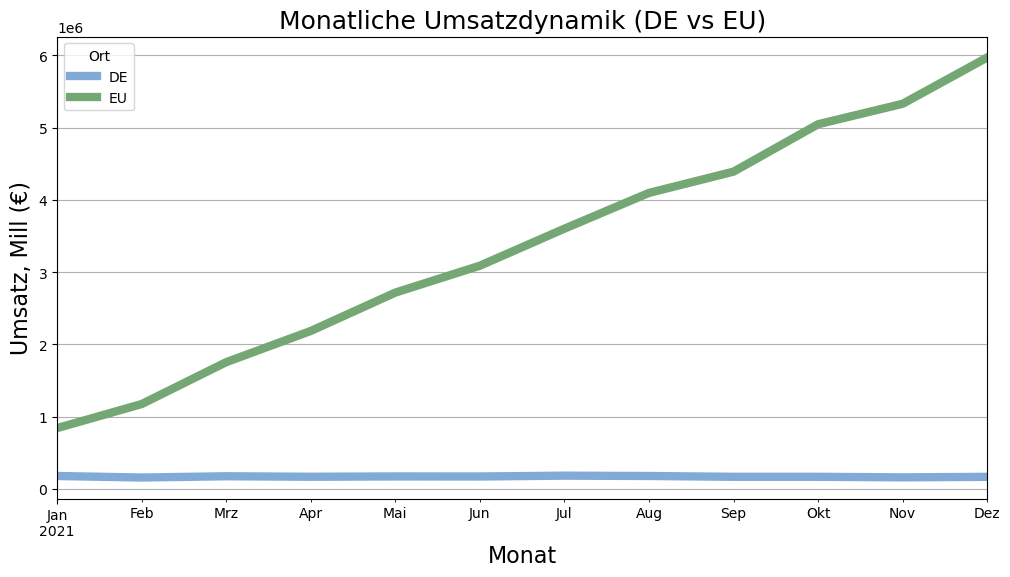

In [36]:
monthly_sales = umsatz_gesamt.groupby(['Monat', 'Ort'])['Umsatz'].sum().unstack()
monthly_sales.plot(figsize=(12, 6), color=["#81ABD6", "#75A775", "#D39C9C"], linewidth=6)

plt.title('Monatliche Umsatzdynamik (DE vs EU)', fontsize=18)  
plt.ylabel('Umsatz, Mill (€)', fontsize=16)
plt.xlabel('Monat', fontsize=16)
plt.grid(True)
plt.show()

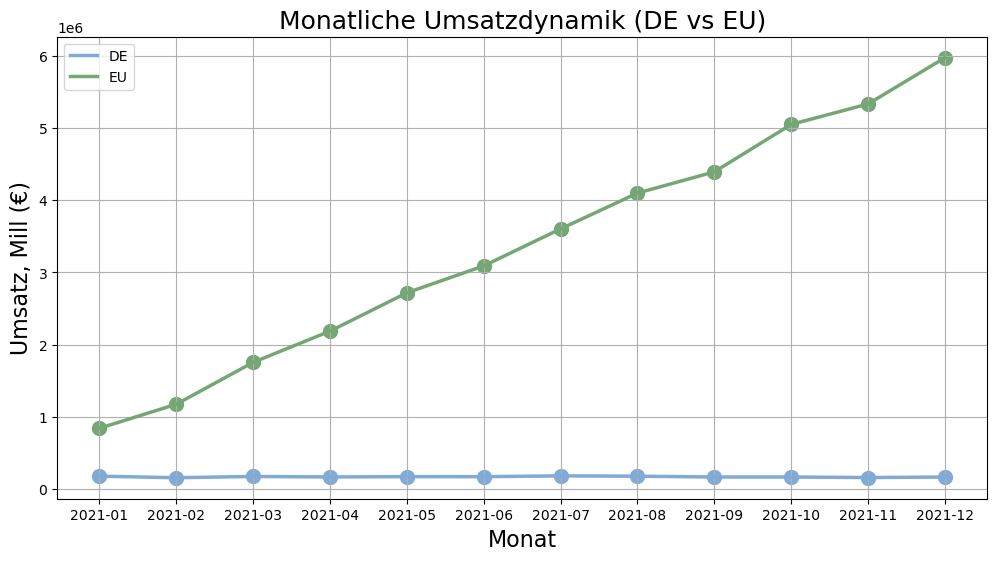

In [37]:
monthly_sales_2 = umsatz_gesamt.groupby(['Monat', 'Ort'])['Umsatz'].sum().unstack()


monthly_sales_2.index = monthly_sales_2.index.astype(str)

plt.figure(figsize=(12, 6))

for col, color in zip(monthly_sales_2.columns, ["#81ABD6", "#75A775", "#D39C9C"]):
    plt.plot(monthly_sales_2.index, monthly_sales_2[col], label=col, color=color, linewidth=2.5)
    plt.scatter(monthly_sales_2.index, monthly_sales_2[col], color=color, s=100)

plt.title('Monatliche Umsatzdynamik (DE vs EU)', fontsize=18)
plt.xlabel('Monat', fontsize=16)
plt.ylabel('Umsatz, Mill (€)', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

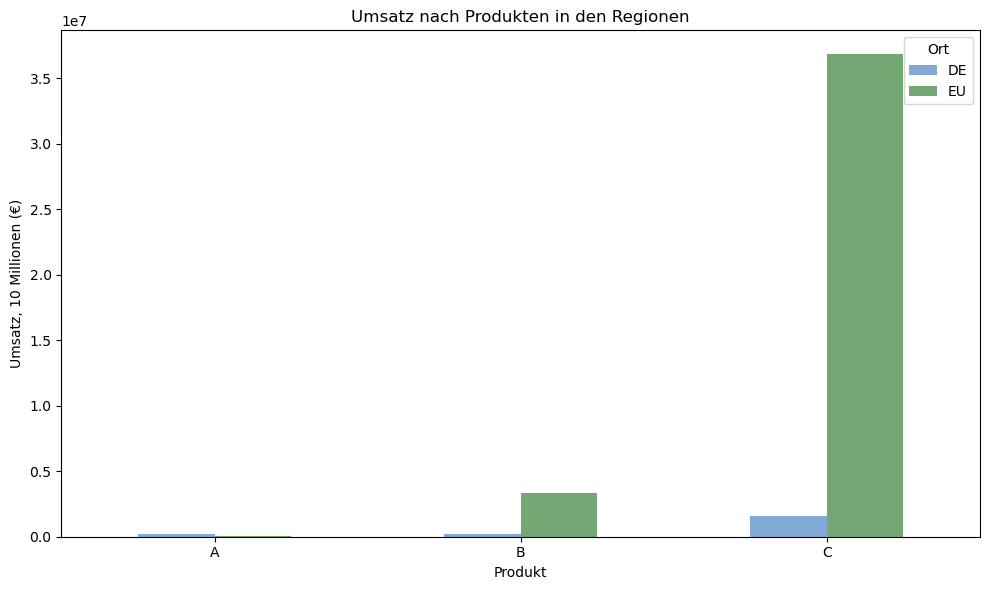

In [38]:
umsatz_gesamt.groupby(['Ort', 'Produkt'])['Umsatz'].sum().unstack().T.plot(kind='bar', figsize=(10,6), color=["#81ABD6", "#75A775"]) 
plt.title('Umsatz nach Produkten in den Regionen')
plt.ylabel('Umsatz, 10 Millionen (€)')
plt.xlabel('Produkt')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
data_freme_de.describe().round(2)

,Datum,Umsatz
count,36,36.00
mean,2021-06-16 12:00:00,57064.66
min,2021-01-01 00:00:00,14055.57
25%,2021-03-24 06:00:00,17446.53
50%,2021-06-16 00:00:00,20386.26
75%,2021-09-08 12:00:00,128886.64
max,2021-12-01 00:00:00,148945.17
std,NaN,55841.39


In [40]:
data_freme_eu.describe().round(2)

,Datum,Umsatz
count,1095,1095.00
mean,2021-07-02 00:00:00,36723.88
min,2021-01-01 00:00:00,0.27
25%,2021-04-02 00:00:00,79.49
50%,2021-07-02 00:00:00,9033.47
75%,2021-10-01 00:00:00,59898.61
max,2021-12-31 00:00:00,180574.57
std,NaN,53032.96


In [41]:
# Konvertiert die Spalte 'Datum' im DataFrame data_freme_eu in datetime-Objekte
data_freme_eu['Datum'] = pd.to_datetime(data_freme_eu['Datum'])

# Extrahiert die Monatsperiode aus der 'Datum'-Spalte und speichert sie in der neuen Spalte 'Monat'
data_freme_eu['Monat'] = data_freme_eu['Datum'].dt.to_period('M')

# Extrahiert die Kalenderwoche aus der 'Datum'-Spalte und speichert sie in der neuen Spalte 'Woche'
data_freme_eu['Woche'] = data_freme_eu['Datum'].dt.isocalendar().week

# Extrahiert den Wochentag als Namen aus der 'Datum'-Spalte und speichert ihn in der neuen Spalte 'Tag'
data_freme_eu['Tag'] = data_freme_eu['Datum'].dt.day_name()

# Gibt die ersten fünf Zeilen des DataFrames aus
data_freme_eu.head()

,Datum,Produkt,Umsatz,Ort,Monat,Woche,Tag
0,2021-01-01,A,17.132115,EU,2021-01,53,Friday
1,2021-01-02,A,57.353725,EU,2021-01,53,Saturday
2,2021-01-03,A,114.746857,EU,2021-01,53,Sunday
3,2021-01-04,A,113.251181,EU,2021-01,1,Monday
4,2021-01-05,A,4.186462,EU,2021-01,1,Tuesday


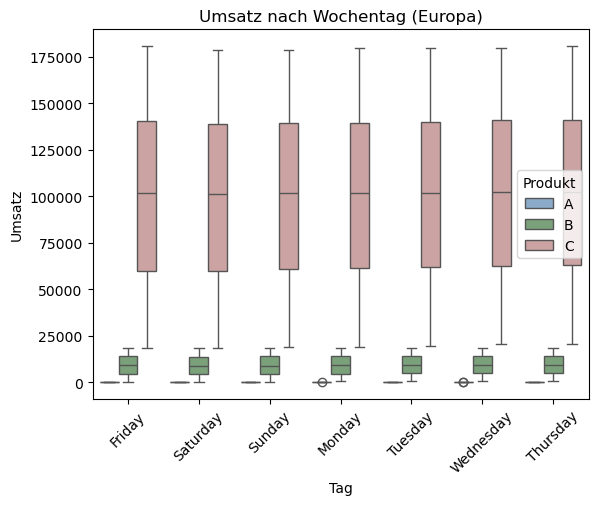

In [42]:
sns.boxplot(data=data_freme_eu, x='Tag', y='Umsatz', hue='Produkt', palette=["#81ABD6", "#75A775", "#D39C9C"] )
plt.title("Umsatz nach Wochentag (Europa)")
plt.xticks(rotation=45)
plt.show()

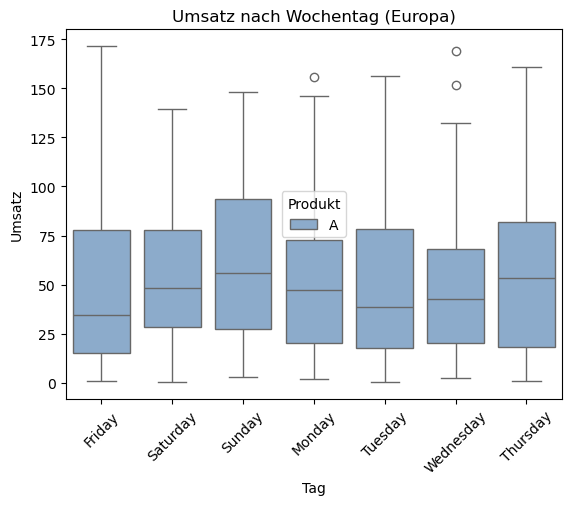

In [43]:
df_filtered_a = data_freme_eu[data_freme_eu["Produkt"] == "A"]

sns.boxplot(data=df_filtered_a, x='Tag', y='Umsatz', hue='Produkt', palette=["#81ABD6"] )
plt.title("Umsatz nach Wochentag (Europa)")
plt.xticks(rotation=45)
plt.show()

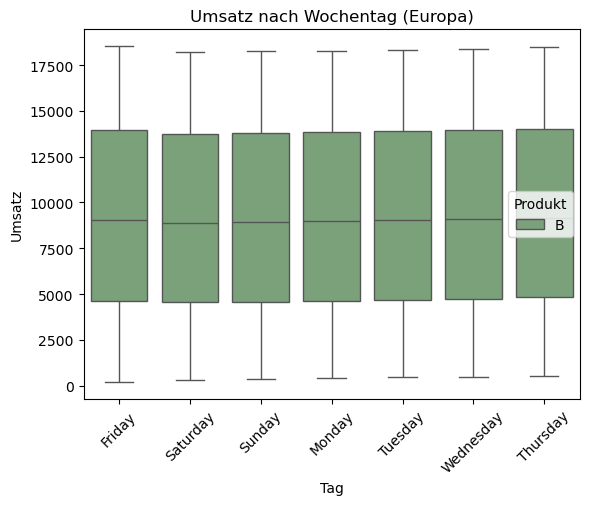

In [44]:
df_filtered_b = data_freme_eu[data_freme_eu["Produkt"] == "B"]

sns.boxplot(data=df_filtered_b, x='Tag', y='Umsatz', hue='Produkt' , palette=[ "#75A775"])
plt.title("Umsatz nach Wochentag (Europa)")
plt.xticks(rotation=45)
plt.show()

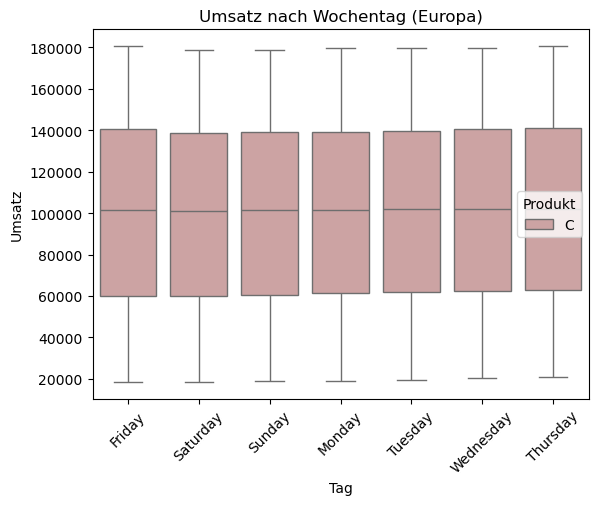

In [45]:
df_filtered_c = data_freme_eu[data_freme_eu["Produkt"] == "C"]

sns.boxplot(data=df_filtered_c, x='Tag', y='Umsatz', hue='Produkt', palette=[ "#D39C9C"])
plt.title("Umsatz nach Wochentag (Europa)")
plt.xticks(rotation=45)
plt.show()

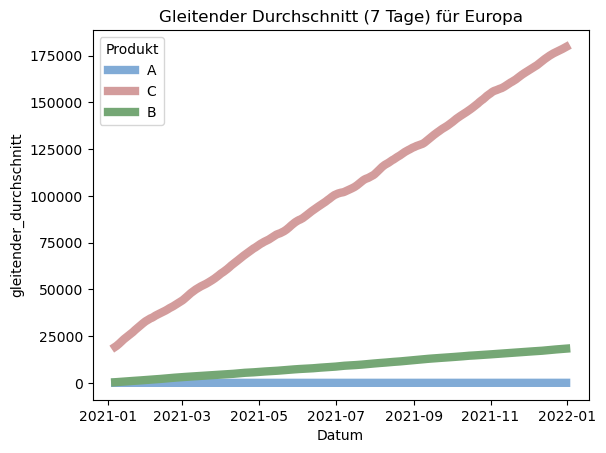

In [46]:
data_freme_eu_sorted = data_freme_eu.sort_values('Datum')
data_freme_eu_sorted['gleitender_durchschnitt'] = data_freme_eu_sorted.groupby('Produkt')['Umsatz'].transform(lambda x: x.rolling(7).mean())

sns.lineplot(data=data_freme_eu_sorted, x='Datum', y='gleitender_durchschnitt', hue='Produkt',  linewidth=6, palette=["#81ABD6","#D39C9C", "#75A775", ])
plt.title("Gleitender Durchschnitt (7 Tage) für Europa")
plt.show()

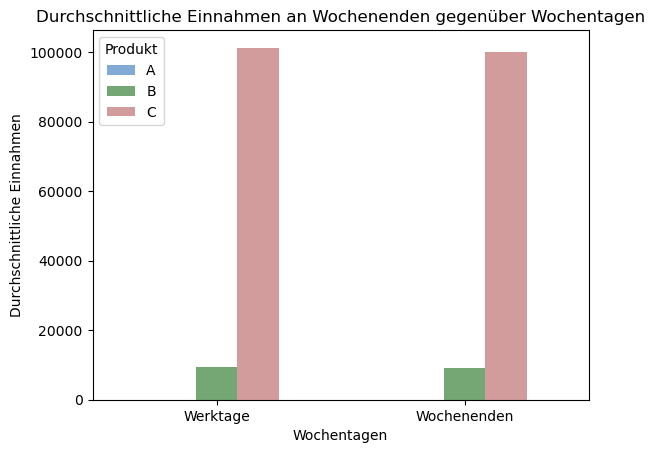

In [47]:
data_freme_eu['Wochenenden'] = data_freme_eu['Tag'].isin(['Saturday', 'Sunday'])

data_freme_eu.groupby(['Wochenenden', 'Produkt'])['Umsatz'].mean().unstack().plot(kind='bar', color=["#81ABD6", "#75A775", "#D39C9C"])
plt.title("Durchschnittliche Einnahmen an Wochenenden gegenüber Wochentagen")
plt.ylabel("Durchschnittliche Einnahmen")
plt.xlabel("Wochentagen")
plt.xticks([0, 1], ['Werktage', 'Wochenenden'], rotation=0)
plt.show()